In [2]:
# Trains the structure-sequence hybrid predictor for classification


# Authored by Aidan Riley 7/1/22

import sys
sys.path.insert(1,'../src')
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras
import matplotlib.pyplot as plt   
import util
import GA_util
import keras.layers
from sklearn.model_selection import train_test_split
from keras import layers
from GA_util import GumbelSoftmax
from sklearn.metrics import roc_curve, auc
print('loaded tf',tf.__version__)

loaded tf 2.10.0


In [3]:
#load the real data, data with just an RBS loop, just a start codon, and data that binds to itself
num_samples = 48000





real_data= np.load('../data/Toehold_data/collins_encoded.npy')
real_data = real_data[:,:,1:]

random_indices = np.random.choice(np.arange(0,real_data.shape[0]), size=num_samples, replace=False)

real_data = real_data[random_indices,:,:]

rbs_data = GA_util.create_rbs_data(8000)
aug_data = GA_util.create_aug_data(8000)
rbs_aug_data = GA_util.create_rbs_aug_data(8000)
binding_data = GA_util.create_binding_data(8000)


full_dataset = np.concatenate((real_data,rbs_data,aug_data,rbs_aug_data,binding_data),axis=0)
y = np.zeros((full_dataset.shape[0],5))

print(full_dataset.shape)
print(y.shape)




(8000, 4, 18)
(80000, 4, 59)
(80000, 5)


In [4]:
# np.save('../data/simulated_dataset_10_23_30.npy',full_dataset)

# np.save('../data/simulated_dataset_targets_10_23_30.npy',full_dataset)

In [5]:
#Assign one-hot encoded labels
# y[:real_data.shape[0]] = 1
# y[real_data.shape[1]:] = 0
y[:real_data.shape[0],0] = 1
y[real_data.shape[0]:real_data.shape[0]+rbs_data.shape[0],1] = 1
y[real_data.shape[0]+rbs_data.shape[0]:real_data.shape[0]+rbs_data.shape[0]+aug_data.shape[0],2] = 1
y[real_data.shape[0]+rbs_data.shape[0]+aug_data.shape[0]:real_data.shape[0]+rbs_data.shape[0]+aug_data.shape[0]+rbs_aug_data.shape[0],3] = 1
y[-rbs_aug_data.shape[0]:,4] = 1

print(np.sum(y[:,0]))
print(np.sum(y[:,1]))
print(np.sum(y[:,2]))
print(np.sum(y[:,3]))
print(np.sum(y[:,4]))

48000.0
8000.0
8000.0
8000.0
8000.0


In [6]:
ppms = GA_util.prototype_ppms_fast(full_dataset)


In [7]:
indices = np.arange(0,full_dataset.shape[0])
seq_train,seq_test,ppm_train,ppm_test,y_train,y_test,train_indices,test_indices= train_test_split(full_dataset,ppms,y,indices,test_size=0.25) 


print(seq_train.shape)
print(ppm_train.shape)
print(y_train.shape)
print(seq_test.shape)
print(ppm_test.shape)
print(y_test.shape)

(60000, 4, 59)
(60000, 59, 59)
(60000, 5)
(20000, 4, 59)
(20000, 59, 59)
(20000, 5)


In [7]:


latent_dim = 16
batch_size = 64
act = 'linear'





def create_discriminator_sequence(kernel_1_size=[4,30],kernel_2_size=[4,9],kernel_3_size=[4,3],latent_dim=16):
#### Predictive Model Definition ####
    input_seqs = keras.Input(shape=(4,59,1))
    #Sequence Branch
    a = layers.Conv2D(latent_dim, kernel_1_size, strides=(4, 1), padding="same",activation=act)(input_seqs)
    a = layers.BatchNormalization()(a)
    a = layers.Conv2D(latent_dim/8,kernel_2_size , strides=(4, 1), padding="same",activation=act)(a)
    a = layers.Conv2D(latent_dim/16,kernel_3_size,strides=(4,1),padding='same',activation=act)(a)
    a = layers.Flatten()(a)

    b = layers.Dense(5,name='classification_output')(a)

    discriminator_sequence  = keras.Model(inputs=input_seqs,outputs=[b],name='discriminator_sequence')
    return discriminator_sequence

tmp = create_discriminator_sequence(kernel_1_size=[4,1],kernel_2_size=[4,1,],kernel_3_size=[4,59])

print(tmp.summary())

def create_discriminator_sandstorm(kernel_1_size=[4,30],kernel_2_size=[4,9],kernel_3_size=[4,3],latent_dim=16):
#### Ensemble Model Definition ####
    input_seqs = keras.Input(shape=(4,59,1))
    input_probs = keras.Input(shape=(59,59,1))
#Same as sequence, but fewer parameters
    c = layers.Conv2D(latent_dim/16, kernel_1_size, strides=(4, 1), padding="same",activation=act)(input_seqs)
    c = layers.BatchNormalization()(c)
    c = layers.Conv2D(latent_dim/16, kernel_2_size, strides=(4, 1), padding="same",activation=act)(c)
    c = layers.Conv2D(latent_dim/16,kernel_3_size,strides=(4,1),padding='same',activation=act)(c)
    c = layers.Flatten()(c)

    # Additional PPM Branch 
    d = layers.Conv2D(latent_dim/16, (8, 8), strides=(2, 2), padding="same",activation=act)(input_probs)
    d = layers.BatchNormalization()(d)
    d = layers.Conv2D(latent_dim/16, (4, 4), strides=(2, 2), padding="same",activation=act)(d)
    d = layers.Conv2D(latent_dim/16,(2,2),strides=(2,2),padding='same',activation=act)(d)
    d = layers.Flatten()(d)


    e = layers.Concatenate()([c,d])
    # c = layers.Dense(10)(c)
    e = layers.Dense(5,name='classification_output')(e)


    discriminator_ensemble = keras.Model(inputs=[input_seqs,input_probs],outputs=[e])
    return discriminator_ensemble
    # discriminator_ensemble.summary()

2024-03-12 19:21:38.815206: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-12 19:21:38.815552: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Ultra
Model: "discriminator_sequence"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 59, 1)]        0         
                                                                 
 conv2d (Conv2D)             (None, 1, 59, 16)         80        
                                                                 
 batch_normalization (BatchN  (None, 1, 59, 16)        64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 59, 2)          130       
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 59, 1)          473       
                                                                 
 flatten (Flatten)           (None, 59)                0         
        

In [19]:
#Train the Sequence Only Model

n_classes=5


kernel_1_sizes = [[1,1]]

for i in range(1,31):
    kernel_1_sizes.append([4,i])

print(kernel_1_sizes)


auc_roc_save = np.zeros(shape=(len(kernel_1_sizes),3))
auc_roc_save_sandstorm = np.zeros(shape=(len(kernel_1_sizes),3))

for i in range(len(kernel_1_sizes)):
    
    kern = kernel_1_sizes[i]
    # kern = [4,12]
    for j in range(3): #three fold repetition with each kernel size
        discriminator_sequence = create_discriminator_sequence(kernel_1_size=kern,
                                               kernel_2_size=[4,9],
                                               kernel_3_size=[4,3])

        discriminator_sequence.compile(optimizer=keras.optimizers.Adam(),
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

        epochs=5
        hist = discriminator_sequence.fit(
            seq_train,y_train,batch_size=64,validation_data=[seq_test,y_test],epochs=epochs)

        y_score_s = discriminator_sequence([seq_test]).numpy()

        fpr_s = dict()
        tpr_s = dict()
        roc_auc_s = dict()
        for k in range(n_classes):
            fpr_s[k], tpr_s[k], _ = roc_curve(y_test[:, k], y_score_s[:, k])
            roc_auc_s[k] = auc(fpr_s[k], tpr_s[k])

        auc_roc_save[i,j] = roc_auc_s[3]
        
        
        discriminator_SANDSTORM = create_discriminator_sandstorm(kernel_1_size=kern,
                                                                kernel_2_size=[4,9],
                                                                kernel_3_size=[4,9],
                                                                latent_dim=16)
        
        discriminator_SANDSTORM.compile(optimizer=keras.optimizers.Adam(),
                                       loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                       metrics=['accuracy'])
        
        epochs=5
        hist_sandstorm = discriminator_SANDSTORM.fit(
        [seq_train,ppm_train],y_train,batch_size=64,validation_data=[[seq_test,ppm_test],y_test],epochs=epochs)
        
        y_score_sandstorm = discriminator_SANDSTORM([seq_test,ppm_test]).numpy()
        
        fpr_sandstorm = dict()
        tpr_sandstorm = dict()
        roc_auc_sandstorm = dict()
        for k in range(n_classes):
            fpr_sandstorm[k], tpr_sandstorm[k], _ = roc_curve(y_test[:, k], y_score_sandstorm[:, k])
            roc_auc_sandstorm[k] = auc(fpr_sandstorm[k], tpr_sandstorm[k])

        auc_roc_save_sandstorm[i,j] = roc_auc_sandstorm[3]

[[1, 1], [4, 1], [4, 2], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [4, 12], [4, 13], [4, 14], [4, 15], [4, 16], [4, 17], [4, 18], [4, 19], [4, 20], [4, 21], [4, 22], [4, 23], [4, 24], [4, 25], [4, 26], [4, 27], [4, 28], [4, 29], [4, 30]]
Epoch 1/5
  6/938 [..............................] - ETA: 10s - loss: 1.5840 - accuracy: 0.2656 

2023-10-29 23:07:07.276224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.6498 - accuracy: 0.7707

2023-10-29 23:07:17.213298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 12s 13ms/step - loss: 0.6498 - accuracy: 0.7707 - val_loss: 0.4407 - val_accuracy: 0.8506
Epoch 2/5
503/938 [===============>..............] - ETA: 4s - loss: 0.4294 - accuracy: 0.8518

KeyboardInterrupt: 

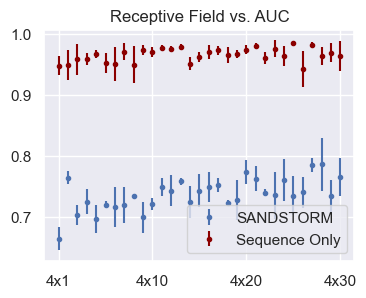

In [9]:
import seaborn as sns

means = np.load('stat_tests/filter_length_sequence_means.npy')
std_dev = np.load('stat_tests/filter_length_sequence_stdvs.npy')

means_sandstorm = np.load('stat_tests/filter_length_sandstorm_means.npy')
std_dev_sandstorm = np.load('stat_tests/filter_length_sandstorm_stdvs.npy')

sns.set_theme(style='darkgrid')


# means = np.mean(auc_roc_save,axis=1)
# std_dev = np.std(auc_roc_save,axis=1)

# means_sandstorm = np.mean(auc_roc_save_sandstorm,axis=1)
# std_dev_sandstorm = np.std(auc_roc_save_sandstorm,axis=1)

plt.figure(figsize=[4,3])
plt.errorbar(x=np.arange(1,means.shape[0]+1),y=means,yerr=std_dev,linestyle='',marker='.')
plt.errorbar(x=np.arange(1,means_sandstorm.shape[0]+1),y=means_sandstorm,yerr=std_dev_sandstorm,linestyle='',marker='.',color='darkred')

plt.title('Receptive Field vs. AUC')
plt.legend(['SANDSTORM','Sequence Only'])
plt.xticks([1,11,21,31],labels=['4x1','4x10','4x20','4x30'])
# plt.ylabel('RBS+AUG Decoy AUC')
# plt.xlabel('Layer 1 Kernel Size (4 X N)')
# sns.scatterplot(x=np.arange(0,means.shape[0]),y=means,color='darkblue')
plt.savefig('../figures/classifier_figs/receptive_field.svg',dpi=1000,transparent=False)


In [204]:
np.save('stat_tests/filter_length_sequence_means.npy',means)
np.save('stat_tests/filter_length_sequence_stdvs.npy',std_dev)

np.save('stat_tests/filter_length_sandstorm_means.npy',means_sandstorm)
np.save('stat_tests/filter_length_sandstorm_stdvs.npy',std_dev_sandstorm)

In [8]:
#Train the Sequence Only Model

n_classes=5


dimensions = [16,32,64,128,256]





auc_roc_save = np.zeros(shape=(len(dimensions),3))

auc_roc_save_sandstorm = np.zeros(shape=(len(dimensions),3))

for i in range(len(dimensions)):
    
    dim = dimensions[i]
    # kern = [4,12]
    for j in range(3): #three fold repetition with each latent_dimension size
        discriminator_sequence = create_discriminator_sequence(kernel_1_size=[4,9],
                                               kernel_2_size=[4,9],
                                               kernel_3_size=[4,3],
                                                latent_dim=dim)

        discriminator_sequence.compile(optimizer=keras.optimizers.Adam(),
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

        epochs=5
        hist = discriminator_sequence.fit(
            seq_train,y_train,batch_size=64,validation_data=[seq_test,y_test],epochs=epochs)

        y_score_s = discriminator_sequence([seq_test]).numpy()

        fpr_s = dict()
        tpr_s = dict()
        roc_auc_s = dict()
        for k in range(n_classes):
            fpr_s[k], tpr_s[k], _ = roc_curve(y_test[:, k], y_score_s[:, k])
            roc_auc_s[k] = auc(fpr_s[k], tpr_s[k])

        auc_roc_save[i,j] = roc_auc_s[3]
        
        
        
        discriminator_SANDSTORM = create_discriminator_sandstorm(kernel_1_size=[4,9],
                                                                kernel_2_size=[4,9],
                                                                kernel_3_size=[4,3],
                                                                latent_dim=dim)
        
        discriminator_SANDSTORM.compile(optimizer=keras.optimizers.Adam(),
                                       loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                       metrics=['accuracy'])
        
        epochs=5
        hist_sandstorm = discriminator_SANDSTORM.fit(
        [seq_train,ppm_train],y_train,batch_size=64,validation_data=[[seq_test,ppm_test],y_test],epochs=epochs)
        
        y_score_sandstorm = discriminator_SANDSTORM([seq_test,ppm_test]).numpy()
        
        fpr_sandstorm = dict()
        tpr_sandstorm = dict()
        roc_auc_sandstorm = dict()
        for k in range(n_classes):
            fpr_sandstorm[k], tpr_sandstorm[k], _ = roc_curve(y_test[:, k], y_score_sandstorm[:, k])
            roc_auc_sandstorm[k] = auc(fpr_sandstorm[k], tpr_sandstorm[k])

        auc_roc_save_sandstorm[i,j] = roc_auc_sandstorm[3]

Epoch 1/5


2024-02-10 17:21:08.720865: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-10 17:21:08.979749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.4701 - accuracy: 0.8447

2024-02-10 17:21:20.110984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 13s 13ms/step - loss: 0.4701 - accuracy: 0.8447 - val_loss: 0.2567 - val_accuracy: 0.9254
Epoch 2/5
938/938 [==============================] - 12s 13ms/step - loss: 0.2409 - accuracy: 0.9316 - val_loss: 0.2227 - val_accuracy: 0.9374
Epoch 3/5
938/938 [==============================] - 12s 13ms/step - loss: 0.2181 - accuracy: 0.9396 - val_loss: 0.2109 - val_accuracy: 0.9409
Epoch 4/5
938/938 [==============================] - 12s 13ms/step - loss: 0.2061 - accuracy: 0.9430 - val_loss: 0.2024 - val_accuracy: 0.9435
Epoch 5/5
938/938 [==============================] - 12s 13ms/step - loss: 0.2022 - accuracy: 0.9448 - val_loss: 0.2025 - val_accuracy: 0.9442
Epoch 1/5


2024-02-10 17:22:10.379402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.4890 - accuracy: 0.8209

2024-02-10 17:22:24.710165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 17s 17ms/step - loss: 0.4890 - accuracy: 0.8209 - val_loss: 0.1503 - val_accuracy: 0.9493
Epoch 2/5
938/938 [==============================] - 15s 16ms/step - loss: 0.1166 - accuracy: 0.9629 - val_loss: 0.0845 - val_accuracy: 0.9733
Epoch 3/5
938/938 [==============================] - 15s 16ms/step - loss: 0.0811 - accuracy: 0.9762 - val_loss: 0.0646 - val_accuracy: 0.9808
Epoch 4/5
938/938 [==============================] - 15s 16ms/step - loss: 0.0676 - accuracy: 0.9803 - val_loss: 0.0558 - val_accuracy: 0.9832
Epoch 5/5
938/938 [==============================] - 16s 17ms/step - loss: 0.0587 - accuracy: 0.9839 - val_loss: 0.0479 - val_accuracy: 0.9861
Epoch 1/5
  6/938 [..............................] - ETA: 11s - loss: 1.4845 - accuracy: 0.4062 

2024-02-10 17:23:29.403049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.4393 - accuracy: 0.8591

2024-02-10 17:23:39.760265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 13s 13ms/step - loss: 0.4393 - accuracy: 0.8591 - val_loss: 0.2384 - val_accuracy: 0.9341
Epoch 2/5
938/938 [==============================] - 12s 13ms/step - loss: 0.2262 - accuracy: 0.9372 - val_loss: 0.2173 - val_accuracy: 0.9405
Epoch 3/5
938/938 [==============================] - 12s 13ms/step - loss: 0.2117 - accuracy: 0.9413 - val_loss: 0.2066 - val_accuracy: 0.9417
Epoch 4/5
938/938 [==============================] - 12s 13ms/step - loss: 0.2047 - accuracy: 0.9431 - val_loss: 0.2000 - val_accuracy: 0.9423
Epoch 5/5
938/938 [==============================] - 12s 13ms/step - loss: 0.2000 - accuracy: 0.9442 - val_loss: 0.2045 - val_accuracy: 0.9433
Epoch 1/5
  1/938 [..............................] - ETA: 6:02 - loss: 2.5086 - accuracy: 0.0938

2024-02-10 17:24:30.463946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.4374 - accuracy: 0.8413

2024-02-10 17:24:43.972361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 16s 17ms/step - loss: 0.4374 - accuracy: 0.8413 - val_loss: 0.1092 - val_accuracy: 0.9654
Epoch 2/5
938/938 [==============================] - 16s 17ms/step - loss: 0.0766 - accuracy: 0.9761 - val_loss: 0.0458 - val_accuracy: 0.9868
Epoch 3/5
938/938 [==============================] - 15s 17ms/step - loss: 0.0410 - accuracy: 0.9884 - val_loss: 0.0277 - val_accuracy: 0.9938
Epoch 4/5
938/938 [==============================] - 16s 17ms/step - loss: 0.0290 - accuracy: 0.9926 - val_loss: 0.0214 - val_accuracy: 0.9952
Epoch 5/5
938/938 [==============================] - 15s 16ms/step - loss: 0.0244 - accuracy: 0.9943 - val_loss: 0.0188 - val_accuracy: 0.9958
Epoch 1/5
  6/938 [..............................] - ETA: 11s - loss: 1.4558 - accuracy: 0.3958 

2024-02-10 17:25:48.986908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


937/938 [============================>.] - ETA: 0s - loss: 0.4611 - accuracy: 0.8507

2024-02-10 17:25:59.447660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 13s 13ms/step - loss: 0.4610 - accuracy: 0.8507 - val_loss: 0.2568 - val_accuracy: 0.9290
Epoch 2/5
938/938 [==============================] - 12s 13ms/step - loss: 0.2355 - accuracy: 0.9356 - val_loss: 0.2205 - val_accuracy: 0.9377
Epoch 3/5
938/938 [==============================] - 12s 13ms/step - loss: 0.2165 - accuracy: 0.9407 - val_loss: 0.2103 - val_accuracy: 0.9425
Epoch 4/5
938/938 [==============================] - 12s 13ms/step - loss: 0.2101 - accuracy: 0.9433 - val_loss: 0.2078 - val_accuracy: 0.9440
Epoch 5/5
938/938 [==============================] - 13s 13ms/step - loss: 0.2062 - accuracy: 0.9446 - val_loss: 0.2040 - val_accuracy: 0.9429
Epoch 1/5
  1/938 [..............................] - ETA: 6:11 - loss: 1.9765 - accuracy: 0.1250

2024-02-10 17:26:52.241325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.5268 - accuracy: 0.8130

2024-02-10 17:27:06.114822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 17s 17ms/step - loss: 0.5268 - accuracy: 0.8130 - val_loss: 0.1316 - val_accuracy: 0.9546
Epoch 2/5
938/938 [==============================] - 16s 17ms/step - loss: 0.0823 - accuracy: 0.9738 - val_loss: 0.0509 - val_accuracy: 0.9842
Epoch 3/5
938/938 [==============================] - 16s 17ms/step - loss: 0.0489 - accuracy: 0.9851 - val_loss: 0.0354 - val_accuracy: 0.9891
Epoch 4/5
938/938 [==============================] - 16s 17ms/step - loss: 0.0376 - accuracy: 0.9893 - val_loss: 0.0313 - val_accuracy: 0.9911
Epoch 5/5
938/938 [==============================] - 16s 17ms/step - loss: 0.0326 - accuracy: 0.9911 - val_loss: 0.0260 - val_accuracy: 0.9928
Epoch 1/5


2024-02-10 17:28:13.153517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.3476 - accuracy: 0.8928

2024-02-10 17:28:24.035080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 13s 14ms/step - loss: 0.3476 - accuracy: 0.8928 - val_loss: 0.2074 - val_accuracy: 0.9433
Epoch 2/5
938/938 [==============================] - 13s 14ms/step - loss: 0.2101 - accuracy: 0.9430 - val_loss: 0.2048 - val_accuracy: 0.9436
Epoch 3/5
938/938 [==============================] - 13s 13ms/step - loss: 0.2048 - accuracy: 0.9444 - val_loss: 0.2019 - val_accuracy: 0.9450
Epoch 4/5
938/938 [==============================] - 13s 14ms/step - loss: 0.2008 - accuracy: 0.9449 - val_loss: 0.1957 - val_accuracy: 0.9447
Epoch 5/5
938/938 [==============================] - 13s 14ms/step - loss: 0.1993 - accuracy: 0.9456 - val_loss: 0.2041 - val_accuracy: 0.9450
Epoch 1/5


2024-02-10 17:29:18.326209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.2707 - accuracy: 0.9072

2024-02-10 17:29:33.859753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 18s 18ms/step - loss: 0.2707 - accuracy: 0.9072 - val_loss: 0.0335 - val_accuracy: 0.9911
Epoch 2/5
938/938 [==============================] - 16s 17ms/step - loss: 0.0266 - accuracy: 0.9934 - val_loss: 0.0209 - val_accuracy: 0.9946
Epoch 3/5
938/938 [==============================] - 16s 17ms/step - loss: 0.0179 - accuracy: 0.9962 - val_loss: 0.0127 - val_accuracy: 0.9979
Epoch 4/5
938/938 [==============================] - 16s 17ms/step - loss: 0.0156 - accuracy: 0.9970 - val_loss: 0.0099 - val_accuracy: 0.9980
Epoch 5/5
938/938 [==============================] - 16s 18ms/step - loss: 0.0135 - accuracy: 0.9974 - val_loss: 0.0213 - val_accuracy: 0.9936
Epoch 1/5
  5/938 [..............................] - ETA: 13s - loss: 1.4009 - accuracy: 0.4344 

2024-02-10 17:30:42.049628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.3443 - accuracy: 0.8933

2024-02-10 17:30:52.971230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 13s 14ms/step - loss: 0.3443 - accuracy: 0.8933 - val_loss: 0.2190 - val_accuracy: 0.9371
Epoch 2/5
938/938 [==============================] - 15s 16ms/step - loss: 0.2136 - accuracy: 0.9424 - val_loss: 0.2056 - val_accuracy: 0.9433
Epoch 3/5
938/938 [==============================] - 13s 14ms/step - loss: 0.2074 - accuracy: 0.9437 - val_loss: 0.1995 - val_accuracy: 0.9445
Epoch 4/5
938/938 [==============================] - 13s 14ms/step - loss: 0.2008 - accuracy: 0.9450 - val_loss: 0.1995 - val_accuracy: 0.9442
Epoch 5/5
938/938 [==============================] - 13s 14ms/step - loss: 0.1996 - accuracy: 0.9453 - val_loss: 0.1963 - val_accuracy: 0.9453
Epoch 1/5


2024-02-10 17:31:51.092917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.2071 - accuracy: 0.9273

2024-02-10 17:32:05.910615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 18s 18ms/step - loss: 0.2071 - accuracy: 0.9273 - val_loss: 0.0287 - val_accuracy: 0.9926
Epoch 2/5
938/938 [==============================] - 16s 18ms/step - loss: 0.0274 - accuracy: 0.9931 - val_loss: 0.0194 - val_accuracy: 0.9954
Epoch 3/5
938/938 [==============================] - 16s 17ms/step - loss: 0.0214 - accuracy: 0.9953 - val_loss: 0.0163 - val_accuracy: 0.9960
Epoch 4/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0185 - accuracy: 0.9959 - val_loss: 0.0154 - val_accuracy: 0.9960
Epoch 5/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0167 - accuracy: 0.9964 - val_loss: 0.0145 - val_accuracy: 0.9965
Epoch 1/5
  1/938 [..............................] - ETA: 4:30 - loss: 1.7505 - accuracy: 0.1406

2024-02-10 17:33:14.965501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.3340 - accuracy: 0.8959

2024-02-10 17:33:25.920062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 13s 14ms/step - loss: 0.3340 - accuracy: 0.8959 - val_loss: 0.2204 - val_accuracy: 0.9383
Epoch 2/5
938/938 [==============================] - 13s 14ms/step - loss: 0.2097 - accuracy: 0.9428 - val_loss: 0.2040 - val_accuracy: 0.9445
Epoch 3/5
938/938 [==============================] - 13s 14ms/step - loss: 0.2041 - accuracy: 0.9449 - val_loss: 0.1975 - val_accuracy: 0.9450
Epoch 4/5
938/938 [==============================] - 13s 14ms/step - loss: 0.1999 - accuracy: 0.9452 - val_loss: 0.2009 - val_accuracy: 0.9450
Epoch 5/5
938/938 [==============================] - 13s 14ms/step - loss: 0.1983 - accuracy: 0.9455 - val_loss: 0.1945 - val_accuracy: 0.9460
Epoch 1/5


2024-02-10 17:34:20.987653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.2036 - accuracy: 0.9285

2024-02-10 17:34:35.784092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 18s 19ms/step - loss: 0.2036 - accuracy: 0.9285 - val_loss: 0.0294 - val_accuracy: 0.9924
Epoch 2/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0259 - accuracy: 0.9939 - val_loss: 0.0172 - val_accuracy: 0.9958
Epoch 3/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0185 - accuracy: 0.9959 - val_loss: 0.0154 - val_accuracy: 0.9968
Epoch 4/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0155 - accuracy: 0.9967 - val_loss: 0.0131 - val_accuracy: 0.9972
Epoch 5/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0143 - accuracy: 0.9970 - val_loss: 0.0125 - val_accuracy: 0.9976
Epoch 1/5


2024-02-10 17:35:45.531581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.2953 - accuracy: 0.9114

2024-02-10 17:35:56.956497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 14s 14ms/step - loss: 0.2953 - accuracy: 0.9114 - val_loss: 0.2374 - val_accuracy: 0.9215
Epoch 2/5
938/938 [==============================] - 14s 14ms/step - loss: 0.2097 - accuracy: 0.9442 - val_loss: 0.2037 - val_accuracy: 0.9439
Epoch 3/5
938/938 [==============================] - 13s 14ms/step - loss: 0.2057 - accuracy: 0.9446 - val_loss: 0.1990 - val_accuracy: 0.9442
Epoch 4/5
938/938 [==============================] - 13s 14ms/step - loss: 0.2018 - accuracy: 0.9453 - val_loss: 0.2018 - val_accuracy: 0.9439
Epoch 5/5
938/938 [==============================] - 13s 14ms/step - loss: 0.2020 - accuracy: 0.9452 - val_loss: 0.1947 - val_accuracy: 0.9456
Epoch 1/5


2024-02-10 17:36:53.631569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.1357 - accuracy: 0.9545

2024-02-10 17:37:08.290320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 18s 18ms/step - loss: 0.1357 - accuracy: 0.9545 - val_loss: 0.0164 - val_accuracy: 0.9963
Epoch 2/5
938/938 [==============================] - 16s 17ms/step - loss: 0.0168 - accuracy: 0.9964 - val_loss: 0.0123 - val_accuracy: 0.9971
Epoch 3/5
938/938 [==============================] - 16s 17ms/step - loss: 0.0145 - accuracy: 0.9971 - val_loss: 0.0138 - val_accuracy: 0.9969
Epoch 4/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0130 - accuracy: 0.9975 - val_loss: 0.0111 - val_accuracy: 0.9974
Epoch 5/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0123 - accuracy: 0.9973 - val_loss: 0.0096 - val_accuracy: 0.9984
Epoch 1/5
  1/938 [..............................] - ETA: 4:54 - loss: 2.0499 - accuracy: 0.0312

2024-02-10 17:38:17.636489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.2941 - accuracy: 0.9130

2024-02-10 17:38:29.067856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 14s 15ms/step - loss: 0.2941 - accuracy: 0.9130 - val_loss: 0.2089 - val_accuracy: 0.9414
Epoch 2/5
938/938 [==============================] - 14s 15ms/step - loss: 0.2116 - accuracy: 0.9436 - val_loss: 0.2160 - val_accuracy: 0.9444
Epoch 3/5
938/938 [==============================] - 14s 14ms/step - loss: 0.2039 - accuracy: 0.9447 - val_loss: 0.2016 - val_accuracy: 0.9436
Epoch 4/5
938/938 [==============================] - 14s 15ms/step - loss: 0.2021 - accuracy: 0.9450 - val_loss: 0.1972 - val_accuracy: 0.9453
Epoch 5/5
938/938 [==============================] - 14s 14ms/step - loss: 0.2000 - accuracy: 0.9453 - val_loss: 0.1981 - val_accuracy: 0.9455
Epoch 1/5


2024-02-10 17:39:26.616556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.1659 - accuracy: 0.9430

2024-02-10 17:39:41.560052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 18s 19ms/step - loss: 0.1659 - accuracy: 0.9430 - val_loss: 0.0178 - val_accuracy: 0.9968
Epoch 2/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0181 - accuracy: 0.9963 - val_loss: 0.0146 - val_accuracy: 0.9975
Epoch 3/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0145 - accuracy: 0.9970 - val_loss: 0.0148 - val_accuracy: 0.9968
Epoch 4/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0129 - accuracy: 0.9974 - val_loss: 0.0124 - val_accuracy: 0.9978
Epoch 5/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0120 - accuracy: 0.9975 - val_loss: 0.0099 - val_accuracy: 0.9980
Epoch 1/5
  1/938 [..............................] - ETA: 4:48 - loss: 1.6108 - accuracy: 0.2188

2024-02-10 17:40:53.123021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.2882 - accuracy: 0.9136

2024-02-10 17:41:04.462770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 14s 15ms/step - loss: 0.2882 - accuracy: 0.9136 - val_loss: 0.2186 - val_accuracy: 0.9385
Epoch 2/5
938/938 [==============================] - 13s 14ms/step - loss: 0.2120 - accuracy: 0.9433 - val_loss: 0.2140 - val_accuracy: 0.9381
Epoch 3/5
938/938 [==============================] - 14s 14ms/step - loss: 0.2051 - accuracy: 0.9448 - val_loss: 0.2014 - val_accuracy: 0.9442
Epoch 4/5
938/938 [==============================] - 14s 14ms/step - loss: 0.2034 - accuracy: 0.9449 - val_loss: 0.1991 - val_accuracy: 0.9437
Epoch 5/5
938/938 [==============================] - 13s 14ms/step - loss: 0.2017 - accuracy: 0.9454 - val_loss: 0.1947 - val_accuracy: 0.9458
Epoch 1/5


2024-02-10 17:42:01.430717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.9549

2024-02-10 17:42:16.025292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 18s 18ms/step - loss: 0.1327 - accuracy: 0.9549 - val_loss: 0.0225 - val_accuracy: 0.9945
Epoch 2/5
938/938 [==============================] - 16s 17ms/step - loss: 0.0180 - accuracy: 0.9961 - val_loss: 0.0120 - val_accuracy: 0.9975
Epoch 3/5
938/938 [==============================] - 16s 17ms/step - loss: 0.0149 - accuracy: 0.9970 - val_loss: 0.0120 - val_accuracy: 0.9980
Epoch 4/5
938/938 [==============================] - 16s 18ms/step - loss: 0.0142 - accuracy: 0.9970 - val_loss: 0.0109 - val_accuracy: 0.9977
Epoch 5/5
938/938 [==============================] - 16s 18ms/step - loss: 0.0124 - accuracy: 0.9976 - val_loss: 0.0154 - val_accuracy: 0.9961
Epoch 1/5


2024-02-10 17:43:25.359690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.2718 - accuracy: 0.9207

2024-02-10 17:43:37.159938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 15s 15ms/step - loss: 0.2718 - accuracy: 0.9207 - val_loss: 0.2109 - val_accuracy: 0.9438
Epoch 2/5
938/938 [==============================] - 13s 14ms/step - loss: 0.2167 - accuracy: 0.9425 - val_loss: 0.2143 - val_accuracy: 0.9402
Epoch 3/5
938/938 [==============================] - 14s 15ms/step - loss: 0.2103 - accuracy: 0.9432 - val_loss: 0.2040 - val_accuracy: 0.9437
Epoch 4/5
938/938 [==============================] - 14s 15ms/step - loss: 0.2093 - accuracy: 0.9438 - val_loss: 0.2086 - val_accuracy: 0.9432
Epoch 5/5
938/938 [==============================] - 14s 14ms/step - loss: 0.2074 - accuracy: 0.9442 - val_loss: 0.1980 - val_accuracy: 0.9456
Epoch 1/5


2024-02-10 17:44:35.737905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.0866 - accuracy: 0.9729

2024-02-10 17:44:50.673117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 18s 18ms/step - loss: 0.0866 - accuracy: 0.9729 - val_loss: 0.0161 - val_accuracy: 0.9963
Epoch 2/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0169 - accuracy: 0.9964 - val_loss: 0.0111 - val_accuracy: 0.9978
Epoch 3/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0147 - accuracy: 0.9971 - val_loss: 0.0109 - val_accuracy: 0.9977
Epoch 4/5
938/938 [==============================] - 17s 19ms/step - loss: 0.0142 - accuracy: 0.9967 - val_loss: 0.0112 - val_accuracy: 0.9981
Epoch 5/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0133 - accuracy: 0.9970 - val_loss: 0.0107 - val_accuracy: 0.9984
Epoch 1/5
  5/938 [..............................] - ETA: 13s - loss: 1.1434 - accuracy: 0.5875 

2024-02-10 17:46:02.602760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.2714 - accuracy: 0.9207

2024-02-10 17:46:14.302672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 15s 15ms/step - loss: 0.2714 - accuracy: 0.9207 - val_loss: 0.2077 - val_accuracy: 0.9419
Epoch 2/5
938/938 [==============================] - 14s 15ms/step - loss: 0.2156 - accuracy: 0.9431 - val_loss: 0.2503 - val_accuracy: 0.9179
Epoch 3/5
938/938 [==============================] - 14s 15ms/step - loss: 0.2117 - accuracy: 0.9429 - val_loss: 0.2025 - val_accuracy: 0.9457
Epoch 4/5
938/938 [==============================] - 14s 15ms/step - loss: 0.2064 - accuracy: 0.9441 - val_loss: 0.2100 - val_accuracy: 0.9451
Epoch 5/5
938/938 [==============================] - 14s 15ms/step - loss: 0.2055 - accuracy: 0.9442 - val_loss: 0.2013 - val_accuracy: 0.9448
Epoch 1/5


2024-02-10 17:47:14.205289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.0885 - accuracy: 0.9724

2024-02-10 17:47:29.344575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 18s 19ms/step - loss: 0.0885 - accuracy: 0.9724 - val_loss: 0.0160 - val_accuracy: 0.9964
Epoch 2/5
938/938 [==============================] - 18s 19ms/step - loss: 0.0159 - accuracy: 0.9966 - val_loss: 0.0116 - val_accuracy: 0.9980
Epoch 3/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0149 - accuracy: 0.9967 - val_loss: 0.0104 - val_accuracy: 0.9985
Epoch 4/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0136 - accuracy: 0.9973 - val_loss: 0.0098 - val_accuracy: 0.9987
Epoch 5/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0135 - accuracy: 0.9969 - val_loss: 0.0110 - val_accuracy: 0.9977
Epoch 1/5
  1/938 [..............................] - ETA: 4:51 - loss: 1.6965 - accuracy: 0.1250

2024-02-10 17:48:42.058189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.2780 - accuracy: 0.9184

2024-02-10 17:48:53.859340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 14s 15ms/step - loss: 0.2780 - accuracy: 0.9184 - val_loss: 0.2120 - val_accuracy: 0.9431
Epoch 2/5
938/938 [==============================] - 14s 15ms/step - loss: 0.2182 - accuracy: 0.9419 - val_loss: 0.2104 - val_accuracy: 0.9412
Epoch 3/5
938/938 [==============================] - 14s 14ms/step - loss: 0.2104 - accuracy: 0.9434 - val_loss: 0.2078 - val_accuracy: 0.9451
Epoch 4/5
938/938 [==============================] - 14s 15ms/step - loss: 0.2079 - accuracy: 0.9440 - val_loss: 0.2027 - val_accuracy: 0.9432
Epoch 5/5
938/938 [==============================] - 14s 15ms/step - loss: 0.2050 - accuracy: 0.9445 - val_loss: 0.2007 - val_accuracy: 0.9451
Epoch 1/5


2024-02-10 17:49:51.632737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9736

2024-02-10 17:50:07.201568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 19s 19ms/step - loss: 0.0808 - accuracy: 0.9736 - val_loss: 0.0128 - val_accuracy: 0.9980
Epoch 2/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0166 - accuracy: 0.9964 - val_loss: 0.0103 - val_accuracy: 0.9980
Epoch 3/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0154 - accuracy: 0.9967 - val_loss: 0.0099 - val_accuracy: 0.9983
Epoch 4/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0133 - accuracy: 0.9972 - val_loss: 0.0094 - val_accuracy: 0.9986
Epoch 5/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0129 - accuracy: 0.9972 - val_loss: 0.0097 - val_accuracy: 0.9982
Epoch 1/5


2024-02-10 17:51:18.660364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.2799 - accuracy: 0.9206

2024-02-10 17:51:32.887699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 17s 18ms/step - loss: 0.2799 - accuracy: 0.9206 - val_loss: 0.2833 - val_accuracy: 0.9313
Epoch 2/5
938/938 [==============================] - 16s 17ms/step - loss: 0.2274 - accuracy: 0.9383 - val_loss: 0.2116 - val_accuracy: 0.9423
Epoch 3/5
938/938 [==============================] - 16s 17ms/step - loss: 0.2172 - accuracy: 0.9414 - val_loss: 0.2217 - val_accuracy: 0.9429
Epoch 4/5
938/938 [==============================] - 16s 17ms/step - loss: 0.2155 - accuracy: 0.9419 - val_loss: 0.2124 - val_accuracy: 0.9449
Epoch 5/5
938/938 [==============================] - 16s 17ms/step - loss: 0.2113 - accuracy: 0.9424 - val_loss: 0.2033 - val_accuracy: 0.9439
Epoch 1/5


2024-02-10 17:52:40.256219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.0602 - accuracy: 0.9810

2024-02-10 17:52:56.708419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 20s 20ms/step - loss: 0.0602 - accuracy: 0.9810 - val_loss: 0.0115 - val_accuracy: 0.9981
Epoch 2/5
938/938 [==============================] - 18s 19ms/step - loss: 0.0196 - accuracy: 0.9954 - val_loss: 0.0193 - val_accuracy: 0.9941
Epoch 3/5
938/938 [==============================] - 18s 19ms/step - loss: 0.0177 - accuracy: 0.9959 - val_loss: 0.0133 - val_accuracy: 0.9968
Epoch 4/5
938/938 [==============================] - 18s 19ms/step - loss: 0.0175 - accuracy: 0.9956 - val_loss: 0.0182 - val_accuracy: 0.9952
Epoch 5/5
938/938 [==============================] - 18s 19ms/step - loss: 0.0158 - accuracy: 0.9962 - val_loss: 0.0129 - val_accuracy: 0.9969
Epoch 1/5
  1/938 [..............................] - ETA: 5:29 - loss: 1.5705 - accuracy: 0.3281

2024-02-10 17:54:12.495157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.2807 - accuracy: 0.9193

2024-02-10 17:54:26.643834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 17s 18ms/step - loss: 0.2807 - accuracy: 0.9193 - val_loss: 0.2371 - val_accuracy: 0.9359
Epoch 2/5
938/938 [==============================] - 17s 18ms/step - loss: 0.2268 - accuracy: 0.9394 - val_loss: 0.2272 - val_accuracy: 0.9297
Epoch 3/5
938/938 [==============================] - 17s 18ms/step - loss: 0.2197 - accuracy: 0.9406 - val_loss: 0.2145 - val_accuracy: 0.9420
Epoch 4/5
938/938 [==============================] - 17s 18ms/step - loss: 0.2160 - accuracy: 0.9414 - val_loss: 0.2063 - val_accuracy: 0.9441
Epoch 5/5
938/938 [==============================] - 17s 18ms/step - loss: 0.2122 - accuracy: 0.9427 - val_loss: 0.2114 - val_accuracy: 0.9429
Epoch 1/5


2024-02-10 17:55:38.025676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9814

2024-02-10 17:55:54.231564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 20s 20ms/step - loss: 0.0603 - accuracy: 0.9814 - val_loss: 0.0156 - val_accuracy: 0.9972
Epoch 2/5
938/938 [==============================] - 19s 20ms/step - loss: 0.0219 - accuracy: 0.9949 - val_loss: 0.0152 - val_accuracy: 0.9959
Epoch 3/5
938/938 [==============================] - 19s 20ms/step - loss: 0.0172 - accuracy: 0.9960 - val_loss: 0.0136 - val_accuracy: 0.9968
Epoch 4/5
938/938 [==============================] - 19s 20ms/step - loss: 0.0163 - accuracy: 0.9962 - val_loss: 0.0145 - val_accuracy: 0.9967
Epoch 5/5
938/938 [==============================] - 18s 20ms/step - loss: 0.0165 - accuracy: 0.9959 - val_loss: 0.0113 - val_accuracy: 0.9974
Epoch 1/5
  1/938 [..............................] - ETA: 5:24 - loss: 1.5635 - accuracy: 0.2500

2024-02-10 17:57:12.917936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.2807 - accuracy: 0.9195

2024-02-10 17:57:27.148860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 17s 18ms/step - loss: 0.2807 - accuracy: 0.9195 - val_loss: 0.2688 - val_accuracy: 0.9161
Epoch 2/5
938/938 [==============================] - 17s 18ms/step - loss: 0.2279 - accuracy: 0.9389 - val_loss: 0.2116 - val_accuracy: 0.9408
Epoch 3/5
938/938 [==============================] - 17s 18ms/step - loss: 0.2185 - accuracy: 0.9406 - val_loss: 0.2046 - val_accuracy: 0.9437
Epoch 4/5
938/938 [==============================] - 17s 18ms/step - loss: 0.2137 - accuracy: 0.9422 - val_loss: 0.2123 - val_accuracy: 0.9435
Epoch 5/5
938/938 [==============================] - 17s 18ms/step - loss: 0.2097 - accuracy: 0.9431 - val_loss: 0.2158 - val_accuracy: 0.9420
Epoch 1/5


2024-02-10 17:58:38.145115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.0551 - accuracy: 0.9830

2024-02-10 17:58:54.394045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 20s 20ms/step - loss: 0.0551 - accuracy: 0.9830 - val_loss: 0.0145 - val_accuracy: 0.9967
Epoch 2/5
938/938 [==============================] - 18s 20ms/step - loss: 0.0214 - accuracy: 0.9949 - val_loss: 0.0109 - val_accuracy: 0.9978
Epoch 3/5
938/938 [==============================] - 18s 19ms/step - loss: 0.0184 - accuracy: 0.9956 - val_loss: 0.0232 - val_accuracy: 0.9920
Epoch 4/5
938/938 [==============================] - 18s 20ms/step - loss: 0.0163 - accuracy: 0.9961 - val_loss: 0.0175 - val_accuracy: 0.9962
Epoch 5/5
938/938 [==============================] - 18s 20ms/step - loss: 0.0153 - accuracy: 0.9966 - val_loss: 0.0119 - val_accuracy: 0.9980


In [ ]:
        y_score_sandstorm = discriminator_SANDSTORM([seq_test,ppm_test]).numpy()
        
        fpr_sandstorm = dict()
        tpr_sandstorm = dict()
        roc_auc_sandstorm = dict()
        for k in range(n_classes):
            fpr_sandstorm[k], tpr_sandstorm[k], _ = roc_curve(y_test[:, k], y_score_sandstorm[:, k])
            roc_auc_sandstorm[k] = auc(fpr_sandstorm[k], tpr_sandstorm[k])

        auc_roc_save_sandstorm[i,j] = roc_auc_sandstorm[3]

16
32
64
128
256


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


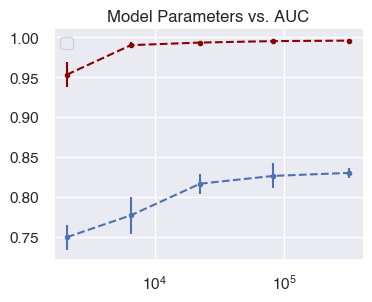

In [19]:
# dim_means = np.load('stat_tests/filter_count_sequence_means.npy')
# dim_std_dev = np.load('stat_tests/filter_count_sequence_stdvs.npy')

# dim_means_sandstorm = np.load('stat_tests/filter_count_sandstorm_means.npy')
# dim_std_dev_sandstorm = np.load('stat_tests/filter_count_sandstorm_stdvs.npy')





param_save = []
dimensions = [16,32,64,128,256]

for i in range(len(dimensions)):
    print(dimensions[i])
    
    tmp = create_discriminator_sequence(kernel_1_size=[4,9],kernel_2_size=[4,9],kernel_3_size=[4,3],latent_dim=dimensions[i])
    param_count = np.sum([np.prod(v.get_shape()) for v in tmp.trainable_weights])
    param_save.append(param_count)



# dim_means = np.mean(auc_roc_save,axis=1)
# dim_std_dev = np.std(auc_roc_save,axis=1)

dim_means = np.load('stat_tests/filter_count_sequence_means.npy')
dim_std_dev = np.load('stat_tests/filter_count_sequence_stdvs.npy')

# dim_means_sandstorm = np.mean(auc_roc_save_sandstorm,axis=1)
# dim_std_dev_sandstorm = np.std(auc_roc_save_sandstorm,axis=1)

dim_means_sandstorm = np.load('stat_tests/filter_count_sandstorm_means.npy')
dim_std_dev_sandstorm = np.load('stat_tests/filter_count_sandstorm_stdvs.npy')

plt.figure(figsize=[4,3])
plt.errorbar(x=param_save,y=dim_means,yerr=dim_std_dev,linestyle='--',marker='.')
# plt.scatter(x=param_save,y=dim_means,color='darkblue',marker='.')

# plt.scatter(x=param_save,y=dim_means_sandstorm,color='darkred',marker='.')
plt.errorbar(x=param_save,y=dim_means_sandstorm,yerr=dim_std_dev_sandstorm,linestyle='--',color='darkred',marker='.')

plt.title('Model Parameters vs. AUC')
# plt.ylabel('RBS+AUG Decoy AUC')
# plt.xlabel('Total Model Parameters')
plt.xscale('log')
plt.legend()
# plt.xlim([1e3,1e6])
util.neat_plot()
plt.savefig('../figures/classifier_figs/model_parameters.svg',transparent=False,dpi=1000)

In [195]:
#Save the filter number alteration run
np.save('stat_tests/filter_count_sequence_means.npy',dim_means)
np.save('stat_tests/filter_count_sequence_stdvs.npy',dim_std_dev)

np.save('stat_tests/filter_count_sandstorm_means.npy',dim_means_sandstorm)
np.save('stat_tests/filter_count_sandstorm_stdvs.npy',dim_std_dev_sandstorm)


In [23]:
#now do the ablation test on the real data dataset



n_classes = 5

num_samples_lst = [2000,4000,8000,16000,32000,48000]

real_data= np.load('../data/Toehold_data/collins_encoded.npy')
real_data = real_data[:,:,1:]


auc_roc_save_data = np.zeros(shape=(len(num_samples_lst),3))
auc_roc_save_sandstorm_data = np.zeros(shape=(len(num_samples_lst),3))



for i in range(len(num_samples_lst)):
    
    num_for_this_iteration = num_samples_lst[i]



    random_indices = np.random.choice(np.arange(0,real_data.shape[0]), size=num_for_this_iteration, replace=True)

    real_data = real_data[random_indices,:,:]

    rbs_data = GA_util.create_rbs_data(8000)
    aug_data = GA_util.create_aug_data(8000)
    rbs_aug_data = GA_util.create_rbs_aug_data(8000)
    binding_data = GA_util.create_binding_data(8000)



    full_dataset = np.concatenate((real_data,rbs_data,aug_data,rbs_aug_data,binding_data),axis=0)
    indices = np.arange(0,full_dataset.shape[0])
    ppms = GA_util.prototype_ppms_fast(full_dataset)
    y = np.zeros((full_dataset.shape[0],5))
    y[:real_data.shape[0],0] = 1
    y[real_data.shape[0]:real_data.shape[0]+rbs_data.shape[0],1] = 1
    y[real_data.shape[0]+rbs_data.shape[0]:real_data.shape[0]+rbs_data.shape[0]+aug_data.shape[0],2] = 1
    y[real_data.shape[0]+rbs_data.shape[0]+aug_data.shape[0]:real_data.shape[0]+rbs_data.shape[0]+aug_data.shape[0]+rbs_aug_data.shape[0],3] = 1
    y[-rbs_aug_data.shape[0]:,4] = 1

    
    seq_train,seq_test,ppm_train,ppm_test,y_train,y_test,indices_train,indices_test= train_test_split(full_dataset,ppms,y,indices,test_size=0.25) 

    # kern = [4,12]
    for j in range(3): #three fold repetition with each kernel size
        discriminator_sequence = create_discriminator_sequence(kernel_1_size=[4,9],
                                               kernel_2_size=[4,9],
                                               kernel_3_size=[4,3])

        discriminator_sequence.compile(optimizer=keras.optimizers.Adam(),
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

        epochs=5
        
        hist = discriminator_sequence.fit(
            seq_train,y_train,batch_size=64,validation_data=[seq_test,y_test],epochs=epochs)

        y_score_s = discriminator_sequence([seq_test]).numpy()

        fpr_s = dict()
        tpr_s = dict()
        roc_auc_s = dict()
        for k in range(n_classes):
            fpr_s[k], tpr_s[k], _ = roc_curve(y_test[:, k], y_score_s[:, k])
            roc_auc_s[k] = auc(fpr_s[k], tpr_s[k])

        auc_roc_save_data[i,j] = roc_auc_s[3]
        
        
        discriminator_SANDSTORM = create_discriminator_sandstorm(kernel_1_size=[4,9],
                                                                kernel_2_size=[4,9],
                                                                kernel_3_size=[4,9],
                                                                latent_dim=16)
        
        discriminator_SANDSTORM.compile(optimizer=keras.optimizers.Adam(),
                                       loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                       metrics=['accuracy'])
        
        epochs=5
        hist_sandstorm = discriminator_SANDSTORM.fit(
        [seq_train,ppm_train],y_train,batch_size=64,validation_data=[[seq_test,ppm_test],y_test],epochs=epochs)
        
        y_score_sandstorm = discriminator_SANDSTORM([seq_test,ppm_test]).numpy()
        
        fpr_sandstorm = dict()
        tpr_sandstorm = dict()
        roc_auc_sandstorm = dict()
        for k in range(n_classes):
            fpr_sandstorm[k], tpr_sandstorm[k], _ = roc_curve(y_test[:, k], y_score_sandstorm[:, k])
            roc_auc_sandstorm[k] = auc(fpr_sandstorm[k], tpr_sandstorm[k])

        auc_roc_save_sandstorm_data[i,j] = roc_auc_sandstorm[3]

(8000, 4, 18)
Epoch 1/5
  4/399 [..............................] - ETA: 7s - loss: 1.6234 - accuracy: 0.2070  

2023-10-29 23:22:40.477032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


399/399 [==============================] - ETA: 0s - loss: 0.6738 - accuracy: 0.7429

2023-10-29 23:22:44.894244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


399/399 [==============================] - 6s 13ms/step - loss: 0.6738 - accuracy: 0.7429 - val_loss: 0.4965 - val_accuracy: 0.8146
Epoch 2/5
399/399 [==============================] - 5s 13ms/step - loss: 0.2747 - accuracy: 0.8995 - val_loss: 0.2326 - val_accuracy: 0.9114
Epoch 3/5
399/399 [==============================] - 5s 13ms/step - loss: 0.2115 - accuracy: 0.9183 - val_loss: 0.1984 - val_accuracy: 0.9244
Epoch 4/5
399/399 [==============================] - 5s 13ms/step - loss: 0.1870 - accuracy: 0.9250 - val_loss: 0.1940 - val_accuracy: 0.9206
Epoch 5/5
399/399 [==============================] - 5s 13ms/step - loss: 0.1755 - accuracy: 0.9297 - val_loss: 0.1795 - val_accuracy: 0.9333
Epoch 1/5


2023-10-29 23:23:06.427635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


399/399 [==============================] - ETA: 0s - loss: 0.9034 - accuracy: 0.6449

2023-10-29 23:23:12.185508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


399/399 [==============================] - 7s 17ms/step - loss: 0.9034 - accuracy: 0.6449 - val_loss: 0.3718 - val_accuracy: 0.8638
Epoch 2/5
399/399 [==============================] - 6s 16ms/step - loss: 0.2233 - accuracy: 0.9238 - val_loss: 0.1452 - val_accuracy: 0.9551
Epoch 3/5
399/399 [==============================] - 6s 16ms/step - loss: 0.1099 - accuracy: 0.9652 - val_loss: 0.0957 - val_accuracy: 0.9706
Epoch 4/5
399/399 [==============================] - 6s 16ms/step - loss: 0.0757 - accuracy: 0.9778 - val_loss: 0.0751 - val_accuracy: 0.9794
Epoch 5/5
399/399 [==============================] - 6s 16ms/step - loss: 0.0590 - accuracy: 0.9835 - val_loss: 0.0650 - val_accuracy: 0.9839
Epoch 1/5
  4/399 [..............................] - ETA: 6s - loss: 1.6016 - accuracy: 0.2695  

2023-10-29 23:23:39.115246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


399/399 [==============================] - ETA: 0s - loss: 0.7229 - accuracy: 0.7154

2023-10-29 23:23:43.512613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


399/399 [==============================] - 6s 13ms/step - loss: 0.7229 - accuracy: 0.7154 - val_loss: 0.5958 - val_accuracy: 0.7613
Epoch 2/5
399/399 [==============================] - 5s 13ms/step - loss: 0.3604 - accuracy: 0.8667 - val_loss: 0.2984 - val_accuracy: 0.8866
Epoch 3/5
399/399 [==============================] - 5s 13ms/step - loss: 0.2641 - accuracy: 0.9011 - val_loss: 0.2334 - val_accuracy: 0.9092
Epoch 4/5
399/399 [==============================] - 5s 13ms/step - loss: 0.2123 - accuracy: 0.9187 - val_loss: 0.2053 - val_accuracy: 0.9180
Epoch 5/5
399/399 [==============================] - 5s 13ms/step - loss: 0.1892 - accuracy: 0.9267 - val_loss: 0.2226 - val_accuracy: 0.9238
Epoch 1/5


2023-10-29 23:24:05.137145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


399/399 [==============================] - ETA: 0s - loss: 0.8769 - accuracy: 0.6607

2023-10-29 23:24:10.955732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


399/399 [==============================] - 7s 17ms/step - loss: 0.8769 - accuracy: 0.6607 - val_loss: 0.3686 - val_accuracy: 0.8627
Epoch 2/5
399/399 [==============================] - 6s 16ms/step - loss: 0.2314 - accuracy: 0.9182 - val_loss: 0.1520 - val_accuracy: 0.9489
Epoch 3/5
399/399 [==============================] - 7s 16ms/step - loss: 0.1275 - accuracy: 0.9574 - val_loss: 0.1111 - val_accuracy: 0.9655
Epoch 4/5
399/399 [==============================] - 6s 16ms/step - loss: 0.1016 - accuracy: 0.9663 - val_loss: 0.1016 - val_accuracy: 0.9684
Epoch 5/5
399/399 [==============================] - 6s 16ms/step - loss: 0.0884 - accuracy: 0.9716 - val_loss: 0.0873 - val_accuracy: 0.9732
Epoch 1/5
  4/399 [..............................] - ETA: 7s - loss: 1.7112 - accuracy: 0.2266  

2023-10-29 23:24:38.235532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


399/399 [==============================] - ETA: 0s - loss: 0.6977 - accuracy: 0.7279

2023-10-29 23:24:42.687022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


399/399 [==============================] - 6s 13ms/step - loss: 0.6977 - accuracy: 0.7279 - val_loss: 0.5191 - val_accuracy: 0.8114
Epoch 2/5
399/399 [==============================] - 5s 13ms/step - loss: 0.2738 - accuracy: 0.8991 - val_loss: 0.2307 - val_accuracy: 0.9174
Epoch 3/5
399/399 [==============================] - 5s 13ms/step - loss: 0.2152 - accuracy: 0.9211 - val_loss: 0.2116 - val_accuracy: 0.9195
Epoch 4/5
399/399 [==============================] - 5s 13ms/step - loss: 0.1950 - accuracy: 0.9275 - val_loss: 0.2137 - val_accuracy: 0.9272
Epoch 5/5
399/399 [==============================] - 5s 13ms/step - loss: 0.1872 - accuracy: 0.9287 - val_loss: 0.2028 - val_accuracy: 0.9209
Epoch 1/5


2023-10-29 23:25:05.073109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


399/399 [==============================] - ETA: 0s - loss: 0.8639 - accuracy: 0.6705

2023-10-29 23:25:11.371543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


399/399 [==============================] - 8s 18ms/step - loss: 0.8639 - accuracy: 0.6705 - val_loss: 0.2892 - val_accuracy: 0.9053
Epoch 2/5
399/399 [==============================] - 7s 17ms/step - loss: 0.1608 - accuracy: 0.9490 - val_loss: 0.0949 - val_accuracy: 0.9729
Epoch 3/5
399/399 [==============================] - 7s 18ms/step - loss: 0.0706 - accuracy: 0.9814 - val_loss: 0.0622 - val_accuracy: 0.9836
Epoch 4/5
399/399 [==============================] - 7s 17ms/step - loss: 0.0475 - accuracy: 0.9889 - val_loss: 0.0489 - val_accuracy: 0.9889
Epoch 5/5
399/399 [==============================] - 7s 17ms/step - loss: 0.0385 - accuracy: 0.9910 - val_loss: 0.0471 - val_accuracy: 0.9898
(8000, 4, 18)
Epoch 1/5


2023-10-29 23:25:46.845646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - ETA: 0s - loss: 0.7696 - accuracy: 0.6805

2023-10-29 23:25:52.532537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - 7s 16ms/step - loss: 0.7696 - accuracy: 0.6805 - val_loss: 0.6164 - val_accuracy: 0.7298
Epoch 2/5
422/422 [==============================] - 6s 14ms/step - loss: 0.3075 - accuracy: 0.8663 - val_loss: 0.2712 - val_accuracy: 0.8810
Epoch 3/5
422/422 [==============================] - 6s 13ms/step - loss: 0.2508 - accuracy: 0.8842 - val_loss: 0.2372 - val_accuracy: 0.8899
Epoch 4/5
422/422 [==============================] - 6s 13ms/step - loss: 0.2295 - accuracy: 0.8921 - val_loss: 0.2280 - val_accuracy: 0.8958
Epoch 5/5
422/422 [==============================] - 6s 13ms/step - loss: 0.2190 - accuracy: 0.8969 - val_loss: 0.2164 - val_accuracy: 0.9038
Epoch 1/5


2023-10-29 23:26:16.671285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - ETA: 0s - loss: 0.7732 - accuracy: 0.6923

2023-10-29 23:26:23.846546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - 9s 20ms/step - loss: 0.7732 - accuracy: 0.6923 - val_loss: 0.2585 - val_accuracy: 0.9163
Epoch 2/5
422/422 [==============================] - 8s 18ms/step - loss: 0.1719 - accuracy: 0.9457 - val_loss: 0.1293 - val_accuracy: 0.9573
Epoch 3/5
422/422 [==============================] - 7s 17ms/step - loss: 0.1095 - accuracy: 0.9677 - val_loss: 0.0956 - val_accuracy: 0.9710
Epoch 4/5
422/422 [==============================] - 7s 17ms/step - loss: 0.0836 - accuracy: 0.9763 - val_loss: 0.0767 - val_accuracy: 0.9784
Epoch 5/5
422/422 [==============================] - 7s 16ms/step - loss: 0.0692 - accuracy: 0.9811 - val_loss: 0.0676 - val_accuracy: 0.9821
Epoch 1/5
  1/422 [..............................] - ETA: 1:58 - loss: 1.6138 - accuracy: 0.2344

2023-10-29 23:26:54.122230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - ETA: 0s - loss: 0.7499 - accuracy: 0.6861

2023-10-29 23:26:58.944516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - 6s 14ms/step - loss: 0.7499 - accuracy: 0.6861 - val_loss: 0.5349 - val_accuracy: 0.7767
Epoch 2/5
422/422 [==============================] - 6s 13ms/step - loss: 0.3384 - accuracy: 0.8530 - val_loss: 0.3026 - val_accuracy: 0.8656
Epoch 3/5
422/422 [==============================] - 6s 13ms/step - loss: 0.2605 - accuracy: 0.8811 - val_loss: 0.2540 - val_accuracy: 0.8859
Epoch 4/5
422/422 [==============================] - 6s 13ms/step - loss: 0.2314 - accuracy: 0.8909 - val_loss: 0.2294 - val_accuracy: 0.8943
Epoch 5/5
422/422 [==============================] - 6s 13ms/step - loss: 0.2181 - accuracy: 0.8979 - val_loss: 0.2192 - val_accuracy: 0.8962
Epoch 1/5


2023-10-29 23:27:22.720826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - ETA: 0s - loss: 0.9257 - accuracy: 0.6232

2023-10-29 23:27:29.171852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - 8s 18ms/step - loss: 0.9257 - accuracy: 0.6232 - val_loss: 0.4239 - val_accuracy: 0.8414
Epoch 2/5
422/422 [==============================] - 7s 18ms/step - loss: 0.1864 - accuracy: 0.9396 - val_loss: 0.1232 - val_accuracy: 0.9592
Epoch 3/5
422/422 [==============================] - 7s 17ms/step - loss: 0.0992 - accuracy: 0.9697 - val_loss: 0.0976 - val_accuracy: 0.9669
Epoch 4/5
422/422 [==============================] - 7s 17ms/step - loss: 0.0772 - accuracy: 0.9767 - val_loss: 0.0731 - val_accuracy: 0.9780
Epoch 5/5
422/422 [==============================] - 8s 18ms/step - loss: 0.0653 - accuracy: 0.9822 - val_loss: 0.0657 - val_accuracy: 0.9781
Epoch 1/5
  1/422 [..............................] - ETA: 2:04 - loss: 1.6435 - accuracy: 0.2344

2023-10-29 23:28:00.211885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - ETA: 0s - loss: 0.7281 - accuracy: 0.7034

2023-10-29 23:28:05.163507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - 6s 14ms/step - loss: 0.7281 - accuracy: 0.7034 - val_loss: 0.5599 - val_accuracy: 0.7734
Epoch 2/5
422/422 [==============================] - 6s 14ms/step - loss: 0.2973 - accuracy: 0.8709 - val_loss: 0.2773 - val_accuracy: 0.8824
Epoch 3/5
422/422 [==============================] - 6s 14ms/step - loss: 0.2474 - accuracy: 0.8900 - val_loss: 0.2474 - val_accuracy: 0.8856
Epoch 4/5
422/422 [==============================] - 6s 14ms/step - loss: 0.2301 - accuracy: 0.8946 - val_loss: 0.2323 - val_accuracy: 0.8909
Epoch 5/5
422/422 [==============================] - 6s 14ms/step - loss: 0.2190 - accuracy: 0.8996 - val_loss: 0.2185 - val_accuracy: 0.9008
Epoch 1/5


2023-10-29 23:28:30.012120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - ETA: 0s - loss: 0.7051 - accuracy: 0.7281

2023-10-29 23:28:36.427322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - 8s 18ms/step - loss: 0.7051 - accuracy: 0.7281 - val_loss: 0.1930 - val_accuracy: 0.9380
Epoch 2/5
422/422 [==============================] - 7s 17ms/step - loss: 0.1339 - accuracy: 0.9571 - val_loss: 0.1127 - val_accuracy: 0.9649
Epoch 3/5
422/422 [==============================] - 7s 17ms/step - loss: 0.0887 - accuracy: 0.9717 - val_loss: 0.0848 - val_accuracy: 0.9737
Epoch 4/5
422/422 [==============================] - 7s 17ms/step - loss: 0.0697 - accuracy: 0.9801 - val_loss: 0.0704 - val_accuracy: 0.9790
Epoch 5/5
422/422 [==============================] - 7s 17ms/step - loss: 0.0581 - accuracy: 0.9843 - val_loss: 0.0596 - val_accuracy: 0.9853
(8000, 4, 18)
Epoch 1/5
  1/469 [..............................] - ETA: 2:15 - loss: 1.6645 - accuracy: 0.2031

2023-10-29 23:29:13.257333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.7595 - accuracy: 0.6734

2023-10-29 23:29:18.806631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 7s 14ms/step - loss: 0.7595 - accuracy: 0.6734 - val_loss: 0.4681 - val_accuracy: 0.8133
Epoch 2/5
469/469 [==============================] - 6s 14ms/step - loss: 0.3240 - accuracy: 0.8620 - val_loss: 0.2960 - val_accuracy: 0.8791
Epoch 3/5
469/469 [==============================] - 6s 13ms/step - loss: 0.2695 - accuracy: 0.8836 - val_loss: 0.2590 - val_accuracy: 0.8824
Epoch 4/5
469/469 [==============================] - 6s 13ms/step - loss: 0.2485 - accuracy: 0.8906 - val_loss: 0.2714 - val_accuracy: 0.8865
Epoch 5/5
469/469 [==============================] - 6s 13ms/step - loss: 0.2382 - accuracy: 0.8963 - val_loss: 0.2409 - val_accuracy: 0.8908
Epoch 1/5


2023-10-29 23:29:45.596719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.7744 - accuracy: 0.6849

2023-10-29 23:29:52.958804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 9s 18ms/step - loss: 0.7744 - accuracy: 0.6849 - val_loss: 0.2499 - val_accuracy: 0.9158
Epoch 2/5
469/469 [==============================] - 8s 17ms/step - loss: 0.1889 - accuracy: 0.9334 - val_loss: 0.1377 - val_accuracy: 0.9538
Epoch 3/5
469/469 [==============================] - 8s 17ms/step - loss: 0.1210 - accuracy: 0.9598 - val_loss: 0.0951 - val_accuracy: 0.9707
Epoch 4/5
469/469 [==============================] - 8s 17ms/step - loss: 0.0883 - accuracy: 0.9710 - val_loss: 0.0724 - val_accuracy: 0.9785
Epoch 5/5
469/469 [==============================] - 8s 17ms/step - loss: 0.0668 - accuracy: 0.9798 - val_loss: 0.0581 - val_accuracy: 0.9844
Epoch 1/5
  1/469 [..............................] - ETA: 2:07 - loss: 1.6333 - accuracy: 0.2812

2023-10-29 23:30:26.391363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.7532 - accuracy: 0.6593

2023-10-29 23:30:31.879561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 7s 14ms/step - loss: 0.7532 - accuracy: 0.6593 - val_loss: 0.6205 - val_accuracy: 0.7122
Epoch 2/5
469/469 [==============================] - 7s 14ms/step - loss: 0.3688 - accuracy: 0.8283 - val_loss: 0.3626 - val_accuracy: 0.8348
Epoch 3/5
469/469 [==============================] - 7s 14ms/step - loss: 0.2925 - accuracy: 0.8695 - val_loss: 0.3031 - val_accuracy: 0.8586
Epoch 4/5
469/469 [==============================] - 6s 14ms/step - loss: 0.2565 - accuracy: 0.8877 - val_loss: 0.2720 - val_accuracy: 0.8665
Epoch 5/5
469/469 [==============================] - 7s 14ms/step - loss: 0.2417 - accuracy: 0.8927 - val_loss: 0.2551 - val_accuracy: 0.8838
Epoch 1/5


2023-10-29 23:30:59.852147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.7686 - accuracy: 0.6750

2023-10-29 23:31:07.200557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 9s 18ms/step - loss: 0.7686 - accuracy: 0.6750 - val_loss: 0.3750 - val_accuracy: 0.8522
Epoch 2/5
469/469 [==============================] - 8s 17ms/step - loss: 0.1579 - accuracy: 0.9474 - val_loss: 0.1222 - val_accuracy: 0.9620
Epoch 3/5
469/469 [==============================] - 8s 18ms/step - loss: 0.1017 - accuracy: 0.9677 - val_loss: 0.0852 - val_accuracy: 0.9744
Epoch 4/5
469/469 [==============================] - 8s 18ms/step - loss: 0.0710 - accuracy: 0.9795 - val_loss: 0.0601 - val_accuracy: 0.9830
Epoch 5/5
469/469 [==============================] - 8s 17ms/step - loss: 0.0513 - accuracy: 0.9869 - val_loss: 0.0525 - val_accuracy: 0.9861
Epoch 1/5
  1/469 [..............................] - ETA: 2:09 - loss: 1.8287 - accuracy: 0.1094

2023-10-29 23:31:41.666139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.7362 - accuracy: 0.6922

2023-10-29 23:31:47.703509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 8s 16ms/step - loss: 0.7362 - accuracy: 0.6922 - val_loss: 0.3903 - val_accuracy: 0.8345
Epoch 2/5
469/469 [==============================] - 7s 14ms/step - loss: 0.3116 - accuracy: 0.8706 - val_loss: 0.2879 - val_accuracy: 0.8762
Epoch 3/5
469/469 [==============================] - 7s 14ms/step - loss: 0.2642 - accuracy: 0.8840 - val_loss: 0.2571 - val_accuracy: 0.8881
Epoch 4/5
469/469 [==============================] - 6s 14ms/step - loss: 0.2443 - accuracy: 0.8948 - val_loss: 0.2527 - val_accuracy: 0.8866
Epoch 5/5
469/469 [==============================] - 7s 14ms/step - loss: 0.2343 - accuracy: 0.8964 - val_loss: 0.2345 - val_accuracy: 0.8987
Epoch 1/5


2023-10-29 23:32:15.673324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.8834 - accuracy: 0.6536

2023-10-29 23:32:23.236118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 9s 19ms/step - loss: 0.8834 - accuracy: 0.6536 - val_loss: 0.2303 - val_accuracy: 0.9298
Epoch 2/5
469/469 [==============================] - 8s 17ms/step - loss: 0.1632 - accuracy: 0.9481 - val_loss: 0.1172 - val_accuracy: 0.9650
Epoch 3/5
469/469 [==============================] - 8s 17ms/step - loss: 0.0928 - accuracy: 0.9718 - val_loss: 0.0762 - val_accuracy: 0.9781
Epoch 4/5
469/469 [==============================] - 8s 17ms/step - loss: 0.0608 - accuracy: 0.9832 - val_loss: 0.0570 - val_accuracy: 0.9852
Epoch 5/5
469/469 [==============================] - 8s 17ms/step - loss: 0.0445 - accuracy: 0.9889 - val_loss: 0.0436 - val_accuracy: 0.9886
(8000, 4, 18)
Epoch 1/5
  1/563 [..............................] - ETA: 6:35 - loss: 1.6815 - accuracy: 0.1719

2023-10-29 23:33:05.565828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


563/563 [==============================] - ETA: 0s - loss: 0.6666 - accuracy: 0.7329

2023-10-29 23:33:12.499897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


563/563 [==============================] - 9s 15ms/step - loss: 0.6666 - accuracy: 0.7329 - val_loss: 0.5377 - val_accuracy: 0.7585
Epoch 2/5
563/563 [==============================] - 8s 14ms/step - loss: 0.3316 - accuracy: 0.8776 - val_loss: 0.3028 - val_accuracy: 0.8834
Epoch 3/5
563/563 [==============================] - 8s 14ms/step - loss: 0.2769 - accuracy: 0.8972 - val_loss: 0.3074 - val_accuracy: 0.8776
Epoch 4/5
563/563 [==============================] - 8s 14ms/step - loss: 0.2569 - accuracy: 0.9035 - val_loss: 0.2531 - val_accuracy: 0.8997
Epoch 5/5
563/563 [==============================] - 8s 14ms/step - loss: 0.2479 - accuracy: 0.9044 - val_loss: 0.2546 - val_accuracy: 0.9068
Epoch 1/5


2023-10-29 23:33:46.097076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


563/563 [==============================] - ETA: 0s - loss: 0.5175 - accuracy: 0.8040

2023-10-29 23:33:54.765581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


563/563 [==============================] - 11s 18ms/step - loss: 0.5175 - accuracy: 0.8040 - val_loss: 0.1270 - val_accuracy: 0.9602
Epoch 2/5
563/563 [==============================] - 10s 17ms/step - loss: 0.0904 - accuracy: 0.9712 - val_loss: 0.0769 - val_accuracy: 0.9764
Epoch 3/5
563/563 [==============================] - 10s 17ms/step - loss: 0.0506 - accuracy: 0.9862 - val_loss: 0.0395 - val_accuracy: 0.9905
Epoch 4/5
563/563 [==============================] - 10s 17ms/step - loss: 0.0329 - accuracy: 0.9920 - val_loss: 0.0289 - val_accuracy: 0.9925
Epoch 5/5
563/563 [==============================] - 10s 17ms/step - loss: 0.0245 - accuracy: 0.9954 - val_loss: 0.0239 - val_accuracy: 0.9945
Epoch 1/5
  1/563 [..............................] - ETA: 2:44 - loss: 1.7146 - accuracy: 0.2344

2023-10-29 23:34:35.563544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


563/563 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.7175

2023-10-29 23:34:42.252257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


563/563 [==============================] - 8s 14ms/step - loss: 0.6906 - accuracy: 0.7175 - val_loss: 0.4272 - val_accuracy: 0.8341
Epoch 2/5
563/563 [==============================] - 8s 14ms/step - loss: 0.3460 - accuracy: 0.8769 - val_loss: 0.3195 - val_accuracy: 0.8843
Epoch 3/5
563/563 [==============================] - 8s 14ms/step - loss: 0.2900 - accuracy: 0.8955 - val_loss: 0.2900 - val_accuracy: 0.8963
Epoch 4/5
563/563 [==============================] - 8s 14ms/step - loss: 0.2697 - accuracy: 0.9013 - val_loss: 0.2710 - val_accuracy: 0.9003
Epoch 5/5
563/563 [==============================] - 8s 14ms/step - loss: 0.2560 - accuracy: 0.9057 - val_loss: 0.2705 - val_accuracy: 0.9046
Epoch 1/5


2023-10-29 23:35:15.084758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


563/563 [==============================] - ETA: 0s - loss: 0.6218 - accuracy: 0.7579

2023-10-29 23:35:23.831963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


563/563 [==============================] - 11s 19ms/step - loss: 0.6218 - accuracy: 0.7579 - val_loss: 0.1759 - val_accuracy: 0.9407
Epoch 2/5
563/563 [==============================] - 10s 17ms/step - loss: 0.1047 - accuracy: 0.9651 - val_loss: 0.0698 - val_accuracy: 0.9795
Epoch 3/5
563/563 [==============================] - 10s 17ms/step - loss: 0.0518 - accuracy: 0.9849 - val_loss: 0.0465 - val_accuracy: 0.9872
Epoch 4/5
563/563 [==============================] - 10s 17ms/step - loss: 0.0358 - accuracy: 0.9909 - val_loss: 0.0371 - val_accuracy: 0.9912
Epoch 5/5
563/563 [==============================] - 10s 17ms/step - loss: 0.0282 - accuracy: 0.9936 - val_loss: 0.0330 - val_accuracy: 0.9914
Epoch 1/5
  1/563 [..............................] - ETA: 2:45 - loss: 1.7877 - accuracy: 0.2344

2023-10-29 23:36:04.962102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


563/563 [==============================] - ETA: 0s - loss: 0.7703 - accuracy: 0.6792

2023-10-29 23:36:11.988080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


563/563 [==============================] - 9s 15ms/step - loss: 0.7703 - accuracy: 0.6792 - val_loss: 0.5147 - val_accuracy: 0.8099
Epoch 2/5
563/563 [==============================] - 8s 14ms/step - loss: 0.3845 - accuracy: 0.8629 - val_loss: 0.3315 - val_accuracy: 0.8858
Epoch 3/5
563/563 [==============================] - 8s 15ms/step - loss: 0.3013 - accuracy: 0.8926 - val_loss: 0.2943 - val_accuracy: 0.8958
Epoch 4/5
563/563 [==============================] - 8s 15ms/step - loss: 0.2730 - accuracy: 0.9007 - val_loss: 0.2679 - val_accuracy: 0.9039
Epoch 5/5
563/563 [==============================] - 8s 14ms/step - loss: 0.2597 - accuracy: 0.9059 - val_loss: 0.2595 - val_accuracy: 0.9051
Epoch 1/5


2023-10-29 23:36:46.640177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


563/563 [==============================] - ETA: 0s - loss: 0.6634 - accuracy: 0.7429

2023-10-29 23:36:55.358599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


563/563 [==============================] - 11s 18ms/step - loss: 0.6634 - accuracy: 0.7429 - val_loss: 0.2127 - val_accuracy: 0.9230
Epoch 2/5
563/563 [==============================] - 10s 18ms/step - loss: 0.1472 - accuracy: 0.9487 - val_loss: 0.1128 - val_accuracy: 0.9597
Epoch 3/5
563/563 [==============================] - 10s 17ms/step - loss: 0.0940 - accuracy: 0.9681 - val_loss: 0.0863 - val_accuracy: 0.9712
Epoch 4/5
563/563 [==============================] - 10s 18ms/step - loss: 0.0700 - accuracy: 0.9775 - val_loss: 0.0594 - val_accuracy: 0.9812
Epoch 5/5
563/563 [==============================] - 10s 18ms/step - loss: 0.0544 - accuracy: 0.9829 - val_loss: 0.0509 - val_accuracy: 0.9837
(8000, 4, 18)
Epoch 1/5
  1/750 [..............................] - ETA: 3:41 - loss: 1.7856 - accuracy: 0.0781

2023-10-29 23:37:46.928792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


749/750 [============================>.] - ETA: 0s - loss: 0.5818 - accuracy: 0.7884

2023-10-29 23:37:55.112536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 10s 13ms/step - loss: 0.5815 - accuracy: 0.7885 - val_loss: 0.3100 - val_accuracy: 0.9015
Epoch 2/5
750/750 [==============================] - 10s 13ms/step - loss: 0.2704 - accuracy: 0.9151 - val_loss: 0.2594 - val_accuracy: 0.9193
Epoch 3/5
750/750 [==============================] - 10s 13ms/step - loss: 0.2400 - accuracy: 0.9247 - val_loss: 0.2470 - val_accuracy: 0.9259
Epoch 4/5
750/750 [==============================] - 10s 13ms/step - loss: 0.2261 - accuracy: 0.9286 - val_loss: 0.2333 - val_accuracy: 0.9269
Epoch 5/5
750/750 [==============================] - 9s 13ms/step - loss: 0.2210 - accuracy: 0.9300 - val_loss: 0.2236 - val_accuracy: 0.9323
Epoch 1/5


2023-10-29 23:38:36.244772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


748/750 [============================>.] - ETA: 0s - loss: 0.4604 - accuracy: 0.8248

2023-10-29 23:38:46.832288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 13s 17ms/step - loss: 0.4596 - accuracy: 0.8251 - val_loss: 0.0973 - val_accuracy: 0.9679
Epoch 2/5
750/750 [==============================] - 12s 16ms/step - loss: 0.0631 - accuracy: 0.9797 - val_loss: 0.0513 - val_accuracy: 0.9837
Epoch 3/5
750/750 [==============================] - 12s 16ms/step - loss: 0.0364 - accuracy: 0.9895 - val_loss: 0.0341 - val_accuracy: 0.9912
Epoch 4/5
750/750 [==============================] - 12s 16ms/step - loss: 0.0258 - accuracy: 0.9934 - val_loss: 0.0290 - val_accuracy: 0.9928
Epoch 5/5
750/750 [==============================] - 12s 16ms/step - loss: 0.0209 - accuracy: 0.9950 - val_loss: 0.0256 - val_accuracy: 0.9942
Epoch 1/5
  1/750 [..............................] - ETA: 3:45 - loss: 1.6758 - accuracy: 0.2031

2023-10-29 23:39:36.270082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


749/750 [============================>.] - ETA: 0s - loss: 0.6326 - accuracy: 0.7743

2023-10-29 23:39:44.334592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 10s 13ms/step - loss: 0.6321 - accuracy: 0.7745 - val_loss: 0.3141 - val_accuracy: 0.9086
Epoch 2/5
750/750 [==============================] - 9s 12ms/step - loss: 0.2523 - accuracy: 0.9222 - val_loss: 0.2411 - val_accuracy: 0.9264
Epoch 3/5
750/750 [==============================] - 10s 13ms/step - loss: 0.2269 - accuracy: 0.9294 - val_loss: 0.2268 - val_accuracy: 0.9320
Epoch 4/5
750/750 [==============================] - 9s 13ms/step - loss: 0.2191 - accuracy: 0.9320 - val_loss: 0.2226 - val_accuracy: 0.9314
Epoch 5/5
750/750 [==============================] - 9s 13ms/step - loss: 0.2158 - accuracy: 0.9321 - val_loss: 0.2202 - val_accuracy: 0.9318
Epoch 1/5


2023-10-29 23:40:24.437542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


747/750 [============================>.] - ETA: 0s - loss: 0.4617 - accuracy: 0.8291

2023-10-29 23:40:35.219905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 13s 17ms/step - loss: 0.4602 - accuracy: 0.8297 - val_loss: 0.0929 - val_accuracy: 0.9697
Epoch 2/5
750/750 [==============================] - 12s 16ms/step - loss: 0.0640 - accuracy: 0.9795 - val_loss: 0.0515 - val_accuracy: 0.9846
Epoch 3/5
750/750 [==============================] - 12s 16ms/step - loss: 0.0404 - accuracy: 0.9884 - val_loss: 0.0378 - val_accuracy: 0.9908
Epoch 4/5
750/750 [==============================] - 12s 16ms/step - loss: 0.0310 - accuracy: 0.9919 - val_loss: 0.0315 - val_accuracy: 0.9926
Epoch 5/5
750/750 [==============================] - 12s 16ms/step - loss: 0.0255 - accuracy: 0.9936 - val_loss: 0.0269 - val_accuracy: 0.9937
Epoch 1/5
  1/750 [..............................] - ETA: 3:49 - loss: 1.6034 - accuracy: 0.2656

2023-10-29 23:41:25.947705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - ETA: 0s - loss: 0.5212 - accuracy: 0.8159

2023-10-29 23:41:34.354697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 11s 14ms/step - loss: 0.5212 - accuracy: 0.8159 - val_loss: 0.2705 - val_accuracy: 0.9177
Epoch 2/5
750/750 [==============================] - 10s 13ms/step - loss: 0.2467 - accuracy: 0.9226 - val_loss: 0.2415 - val_accuracy: 0.9238
Epoch 3/5
750/750 [==============================] - 10s 13ms/step - loss: 0.2281 - accuracy: 0.9275 - val_loss: 0.2351 - val_accuracy: 0.9281
Epoch 4/5
750/750 [==============================] - 10s 13ms/step - loss: 0.2209 - accuracy: 0.9304 - val_loss: 0.2285 - val_accuracy: 0.9283
Epoch 5/5
750/750 [==============================] - 10s 13ms/step - loss: 0.2176 - accuracy: 0.9309 - val_loss: 0.2193 - val_accuracy: 0.9320
Epoch 1/5


2023-10-29 23:42:15.978957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


747/750 [============================>.] - ETA: 0s - loss: 0.5485 - accuracy: 0.7964

2023-10-29 23:42:26.824550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 13s 17ms/step - loss: 0.5468 - accuracy: 0.7970 - val_loss: 0.1353 - val_accuracy: 0.9549
Epoch 2/5
750/750 [==============================] - 12s 16ms/step - loss: 0.0857 - accuracy: 0.9731 - val_loss: 0.0654 - val_accuracy: 0.9788
Epoch 3/5
750/750 [==============================] - 13s 17ms/step - loss: 0.0459 - accuracy: 0.9868 - val_loss: 0.0460 - val_accuracy: 0.9868
Epoch 4/5
750/750 [==============================] - 12s 16ms/step - loss: 0.0310 - accuracy: 0.9921 - val_loss: 0.0385 - val_accuracy: 0.9888
Epoch 5/5
750/750 [==============================] - 12s 16ms/step - loss: 0.0246 - accuracy: 0.9939 - val_loss: 0.0326 - val_accuracy: 0.9921
(8000, 4, 18)
Epoch 1/5
  1/938 [..............................] - ETA: 10:41 - loss: 1.7343 - accuracy: 0.1250

2023-10-29 23:43:30.733097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.5045 - accuracy: 0.8294

2023-10-29 23:43:42.368188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 15s 15ms/step - loss: 0.5045 - accuracy: 0.8294 - val_loss: 0.3242 - val_accuracy: 0.8973
Epoch 2/5
938/938 [==============================] - 14s 15ms/step - loss: 0.2669 - accuracy: 0.9262 - val_loss: 0.2423 - val_accuracy: 0.9345
Epoch 3/5
938/938 [==============================] - 14s 15ms/step - loss: 0.2277 - accuracy: 0.9382 - val_loss: 0.2116 - val_accuracy: 0.9413
Epoch 4/5
938/938 [==============================] - 14s 15ms/step - loss: 0.2144 - accuracy: 0.9422 - val_loss: 0.2156 - val_accuracy: 0.9407
Epoch 5/5
938/938 [==============================] - 14s 15ms/step - loss: 0.2075 - accuracy: 0.9440 - val_loss: 0.2137 - val_accuracy: 0.9443
Epoch 1/5


2023-10-29 23:44:40.887893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.3962 - accuracy: 0.8566

2023-10-29 23:44:55.555909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 18s 19ms/step - loss: 0.3962 - accuracy: 0.8566 - val_loss: 0.1040 - val_accuracy: 0.9640
Epoch 2/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0756 - accuracy: 0.9747 - val_loss: 0.0568 - val_accuracy: 0.9815
Epoch 3/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0485 - accuracy: 0.9849 - val_loss: 0.0420 - val_accuracy: 0.9872
Epoch 4/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0375 - accuracy: 0.9888 - val_loss: 0.0338 - val_accuracy: 0.9905
Epoch 5/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0305 - accuracy: 0.9913 - val_loss: 0.0285 - val_accuracy: 0.9925
Epoch 1/5
  1/938 [..............................] - ETA: 4:54 - loss: 1.8360 - accuracy: 0.1719

2023-10-29 23:46:06.402501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.4613 - accuracy: 0.8497

2023-10-29 23:46:17.744989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 14s 15ms/step - loss: 0.4613 - accuracy: 0.8497 - val_loss: 0.2442 - val_accuracy: 0.9381
Epoch 2/5
938/938 [==============================] - 14s 15ms/step - loss: 0.2236 - accuracy: 0.9378 - val_loss: 0.2142 - val_accuracy: 0.9422
Epoch 3/5
938/938 [==============================] - 14s 15ms/step - loss: 0.2068 - accuracy: 0.9430 - val_loss: 0.2033 - val_accuracy: 0.9451
Epoch 4/5
938/938 [==============================] - 14s 15ms/step - loss: 0.1993 - accuracy: 0.9448 - val_loss: 0.2085 - val_accuracy: 0.9476
Epoch 5/5
938/938 [==============================] - 14s 15ms/step - loss: 0.1969 - accuracy: 0.9452 - val_loss: 0.1926 - val_accuracy: 0.9455
Epoch 1/5


2023-10-29 23:47:15.844956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.3868 - accuracy: 0.8575

2023-10-29 23:47:30.802461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 18s 19ms/step - loss: 0.3868 - accuracy: 0.8575 - val_loss: 0.0940 - val_accuracy: 0.9664
Epoch 2/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0641 - accuracy: 0.9796 - val_loss: 0.0509 - val_accuracy: 0.9845
Epoch 3/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0391 - accuracy: 0.9883 - val_loss: 0.0363 - val_accuracy: 0.9898
Epoch 4/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0283 - accuracy: 0.9923 - val_loss: 0.0259 - val_accuracy: 0.9928
Epoch 5/5
938/938 [==============================] - 18s 19ms/step - loss: 0.0224 - accuracy: 0.9943 - val_loss: 0.0226 - val_accuracy: 0.9942
Epoch 1/5
  1/938 [..............................] - ETA: 5:05 - loss: 1.6467 - accuracy: 0.1562

2023-10-29 23:48:44.002894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.4617 - accuracy: 0.8451

2023-10-29 23:48:56.077903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 15s 16ms/step - loss: 0.4617 - accuracy: 0.8451 - val_loss: 0.2437 - val_accuracy: 0.9317
Epoch 2/5
938/938 [==============================] - 14s 15ms/step - loss: 0.2308 - accuracy: 0.9351 - val_loss: 0.2131 - val_accuracy: 0.9401
Epoch 3/5
938/938 [==============================] - 14s 15ms/step - loss: 0.2123 - accuracy: 0.9411 - val_loss: 0.2062 - val_accuracy: 0.9428
Epoch 4/5
938/938 [==============================] - 14s 15ms/step - loss: 0.2035 - accuracy: 0.9435 - val_loss: 0.2000 - val_accuracy: 0.9444
Epoch 5/5
938/938 [==============================] - 14s 15ms/step - loss: 0.1999 - accuracy: 0.9443 - val_loss: 0.1963 - val_accuracy: 0.9461
Epoch 1/5


2023-10-29 23:49:54.974234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.3616 - accuracy: 0.8673

2023-10-29 23:50:09.823883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 18s 19ms/step - loss: 0.3616 - accuracy: 0.8673 - val_loss: 0.0763 - val_accuracy: 0.9814
Epoch 2/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0465 - accuracy: 0.9856 - val_loss: 0.0339 - val_accuracy: 0.9893
Epoch 3/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0281 - accuracy: 0.9922 - val_loss: 0.0227 - val_accuracy: 0.9945
Epoch 4/5
938/938 [==============================] - 18s 19ms/step - loss: 0.0221 - accuracy: 0.9945 - val_loss: 0.0263 - val_accuracy: 0.9945
Epoch 5/5
938/938 [==============================] - 17s 19ms/step - loss: 0.0179 - accuracy: 0.9959 - val_loss: 0.0197 - val_accuracy: 0.9961


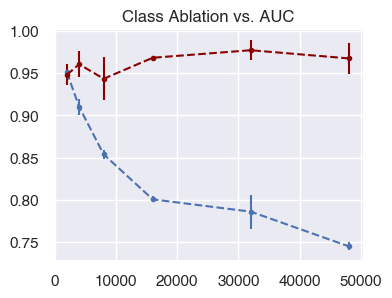

In [20]:
num_samples_lst = [2000,4000,8000,16000,32000,48000]
dim_means_data = np.load('stat_tests/data_ablation_sequence_means.npy')
dim_std_dev_data = np.load('stat_tests/data_ablation_sequence_std_devs.npy')

dim_means_sandstorm_data = np.load('stat_tests/data_ablation_sandstorm_means.npy')
dim_std_dev_sandstorm_data = np.load('stat_tests/data_ablation_sandstorm_std_devs.npy')




# dim_means_data = np.mean(auc_roc_save_data,axis=1)
# dim_std_dev_data = np.std(auc_roc_save_data,axis=1)

# dim_means_sandstorm_data = np.mean(auc_roc_save_sandstorm_data,axis=1)
# dim_std_dev_sandstorm_data = np.std(auc_roc_save_sandstorm_data,axis=1)



plt.figure(figsize=[4,3])
plt.errorbar(x=num_samples_lst,y=dim_means_data,yerr=dim_std_dev_data,linestyle='--',marker='.')
# plt.scatter(x=param_save,y=dim_means,color='darkblue',marker='.')

# plt.scatter(x=param_save,y=dim_means_sandstorm,color='darkred',marker='.')
plt.errorbar(x=num_samples_lst,y=dim_means_sandstorm_data,yerr=dim_std_dev_sandstorm_data,linestyle='--',color='darkred',marker='.')

plt.title('Class Ablation vs. AUC')
# plt.ylabel('RBS+AUG Decoy AUC')
# plt.xlabel('Number of AUG+RBS Decoys in Dataset')
# plt.xscale('log')
# plt.legend()
# plt.xlim([1e3,1e6])
util.neat_plot()
plt.savefig('../figures/classifier_figs/data_ablation.svg',dpi=1000,transparent=False)

In [45]:
np.save('stat_tests/data_ablation_sequence_means.npy',dim_means_data)
np.save('stat_tests/data_ablation_sequence_std_devs.npy',dim_std_dev_data)

np.save('stat_tests/data_ablation_sandstorm_means.npy',dim_means_sandstorm_data)
np.save('stat_tests/data_ablation_sandstorm_std_devs.npy',dim_std_dev_sandstorm_data)

In [ ]:
for i in range(3):
    plt.imshow(ppms[i,:,:],cmap='hot')
    plt.show()
    # plt.savefig('../figures/ppms_%s.svg'%(i),transparent=True)

In [30]:
print(dim_means_sandstorm_data.shape)

(31,)
